# Loads packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.optim as optim
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import sys,os
sys.path.append(os.path.realpath('./src/'))
import pandas as pd
from materialEncoder import MaterialEncoder
import time
import itertools

# Defines functions

In [2]:
def to_np(x):
  return x.detach().cpu().numpy()

def to_torch(x):
  return torch.tensor(x).float()

# Loads the Database

In [3]:
def preprocessData():
  df = pd.read_excel('./data/MaterialDatabase_FULL.xlsx')# # 
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]} # name of the material and type
  trainInfo = np.log10(df[df.columns[3:]].to_numpy())
  dataScaleMax = torch.tensor(np.max(trainInfo, axis = 0))
  dataScaleMin = torch.tensor(np.min(trainInfo, axis = 0))
  normalizedData = (torch.tensor(trainInfo) - dataScaleMin)/(dataScaleMax - dataScaleMin)
  trainingData = torch.tensor(normalizedData).float()
  dataInfo = {'youngsModulus':{'idx':0,'scaleMin':dataScaleMin[0], 'scaleMax':dataScaleMax[0]},\
              'costPerKg':{'idx':1,'scaleMin':dataScaleMin[1], 'scaleMax':dataScaleMax[1]},\
              'massDensity':{'idx':2,'scaleMin':dataScaleMin[2], 'scaleMax':dataScaleMax[2]},\
              'yieldStrength':{'idx':3,'scaleMin':dataScaleMin[3], 'scaleMax':dataScaleMax[3]},\
              'co2Kg':{'idx':4,'scaleMin':dataScaleMin[4], 'scaleMax':dataScaleMax[4]},\
              'energyKg':{'idx':5,'scaleMin':dataScaleMin[5], 'scaleMax':dataScaleMax[5]},\
              'waterKg':{'idx':6,'scaleMin':dataScaleMin[6], 'scaleMax':dataScaleMax[6]}}

  return trainingData, dataInfo, dataIdentifier, trainInfo, df
trainingData, dataInfo, dataIdentifier, trainInfo, df = preprocessData()
numMaterialsInTrainingData, numFeatures = trainingData.shape
props = df.columns[3:].tolist()

C:\Users\luisy\AppData\Local\Temp\ipykernel_14024\405064810.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainingData = torch.tensor(normalizedData).float()


# Trains the VAE

In [4]:
latentDim, hiddenDim = 2, 250
numEpochs = 50000
epsilon=4.2e-2
epsilon=2e-2
numEpochs = 50000
klFactor = 5e-5
learningRate = 2e-3
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}

materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)

start = time.perf_counter()
convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate, epsilon)
print('training time : {:.2F} '.format(time.perf_counter() - start))

Iter 0 reconLoss 4.68E+01 klLoss 5.67E-03 loss 4.68E+01
Iter 500 reconLoss 2.33E-01 klLoss 6.02E-02 loss 2.93E-01
Iter 1000 reconLoss 1.08E-01 klLoss 5.91E-02 loss 1.67E-01
Iter 1500 reconLoss 7.33E-02 klLoss 5.82E-02 loss 1.32E-01
Iter 2000 reconLoss 6.02E-02 klLoss 5.65E-02 loss 1.17E-01
Iter 2500 reconLoss 4.35E-02 klLoss 5.46E-02 loss 9.81E-02
Iter 3000 reconLoss 4.59E-02 klLoss 5.28E-02 loss 9.87E-02
Iter 3500 reconLoss 3.41E-02 klLoss 5.15E-02 loss 8.56E-02
Iter 4000 reconLoss 3.73E-02 klLoss 5.02E-02 loss 8.75E-02
Iter 4500 reconLoss 3.03E-02 klLoss 4.89E-02 loss 7.91E-02
Iter 5000 reconLoss 2.83E-02 klLoss 4.79E-02 loss 7.62E-02
Iter 5500 reconLoss 2.79E-02 klLoss 4.69E-02 loss 7.48E-02
Iter 6000 reconLoss 3.14E-02 klLoss 4.57E-02 loss 7.71E-02
Iter 6500 reconLoss 2.66E-02 klLoss 4.51E-02 loss 7.17E-02
Iter 7000 reconLoss 2.86E-02 klLoss 4.37E-02 loss 7.23E-02
Iter 7500 reconLoss 2.24E-02 klLoss 4.34E-02 loss 6.58E-02
Iter 8000 reconLoss 3.74E-02 klLoss 4.33E-02 loss 8.07E-02
I

# Import the Truss

In [5]:
from examples import getExample
from trussFE import TrussFE

#Loads the example truss
exampleName, nodeXY, connectivity, bc = getExample(4)
#Changes the force
bc['forces'] = {'nodes':np.array([2]), 'fx':1.E3*torch.tensor([0.]), 'fy':1.E2*torch.tensor([125.])}

#Loads the truss in truss
truss = TrussFE(nodeXY, connectivity, bc)

# Gets the z coordinates of each material

In [6]:
vae = materialEncoder.vaeNet
#In decoded there are the decoded properties of each material
#decoded = vae.decoder(vae.encoder.z)
#In z_np are the coordinates of each real material in the latent space
z_np = to_np(vae.encoder.z)
#I get the minimum and maximum z to restrict my boundaries of latent space
z0min, z1min = 0.95*np.min(z_np, axis=0)
z0max, z1max = 1.05*np.max(z_np, axis=0)

nprops=len(props)
max_scale = np.empty(nprops)
min_scale = np.empty(nprops)

#Gets minimum and maximum of each property
for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    max_scale[idx] = materialEncoder.dataInfo[p]['scaleMax']
    min_scale[idx] = materialEncoder.dataInfo[p]['scaleMin']

# Defines objective and constraints

In [7]:
#Defines constraints and objectives
constraints = {'massCons': {'isOn':False, 'maxMass':5}, \
               'costCons': {'isOn':False, 'maxCost':5},\
               'tensionCons': {'isOn':True, 'FOS':4.},\
               'complianceCons': {'isOn':False, 'maxJ':35},\
               'compressionCons': {'isOn':True, 'FOS':4.},\
               'co2Cons': {'isOn':False, 'maxco2':30},\
               'energyCons': {'isOn':False, 'maxenergy' : 1e10},\
               'waterCons': {'isOn':False, 'maxwater':4e3},\
               'confidenceCons': {'isOn':False, 'minconf':95}}


objectives = {'cost': {'isOn':True},\
              'mass': {'isOn':False}, \
              'co2': {'isOn':False},\
              'water': {'isOn':False},\
              'energy': {'isOn':False},\
              'compliance': {'isOn': False}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 2:
    print('Error: Two or more entries have isOn=True')

# Defines the problem

In [8]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self, truss, z_np, constraints, objectives, no, nc):
        super().__init__(n_var=8,
                         n_obj=no,
                         n_ieq_constr=nc,
                         xl=np.array([z0min, z1min, 2e-6, 2e-6, 2e-6, 2e-6, 2e-6, 2e-6]),
                         xu=np.array([z0max, z1max, 2e-2, 2e-2, 2e-2, 2e-2, 2e-2, 2e-2]))

        self.truss=truss
        self.z_np=z_np
        self.constraints=constraints
        self.objectives=objectives

    def _evaluate(self, x, out, *args, **kwargs):
        Z = torch.zeros((1, vaeSettings['encoder']['latentDim']))
        Z[:,0]=x[0]
        Z[:,1]=x[1]

        
        matprop=np.empty(7)
        #Decodes the properties of Z
        decoded = vae.decoder(Z)
        #Scales properties
        for i in range(0,nprops): 
            matprop[i] = 10.**(min_scale[i] + decoded[:,i]*(max_scale[i] - min_scale[i]))
            
        
        x_tensor = torch.from_numpy(x[2:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 

        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        if(constraints['confidenceCons']['isOn']):
            zData=x[0:2]
            dist= np.linalg.norm(zData- z_np, axis = 1)
            maxDist = np.max(dist)
            distOrder = np.argsort(dist)
            confidence_level = 100.*(1.- (dist[distOrder[0]]/maxDist))
            constraints['confidenceCons']['value'] = 1 - (confidence_level/constraints['confidenceCons']['minconf'])
            con_values.append(constraints['confidenceCons']['value'])        
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)        
        

problem = MyProblem(truss, z_np, constraints, objectives, no, nc)

# Defines the problem settings

In [9]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

#pop_size: Size of initial population
#n_offsprings: The number of offspring generated in each generation of the algorithm. 
#sampling: The sampling method used to generate new individuals in the offspring population.
    #In this case, FloatRandomSampling is used, which generates random floating-point values
    #in the search space to create new individuals.
#crossover: The crossover operator used to create new individuals in the offspring population.
#mutation: The mutation operator used to create new individuals in the offspring population.
#eliminate_duplicates: A flag to indicate whether duplicate individuals should be eliminated from the population or not.
algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.7, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultMultiObjectiveTermination

#termination = get_termination("n_gen", 150)

termination = DefaultMultiObjectiveTermination(
    xtol=1e-4,
    cvtol=1e-9,
    ftol=0.0001,
    period=20,
    n_max_gen=500,
    n_max_evals=50000
)

# Runs the solver

In [10]:
from pymoo.optimize import minimize
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
print('solving time : {:.2F} '.format(time.perf_counter() - start))

C:\Users\luisy\Desktop\SMSUDL-paper\src\trussFE.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  Kasm = torch.sparse_coo_tensor(self.nodeIdx, sK,\


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  0.000000E+00 |  8.296225E+01 |             - |             -
     2 |       50 |      1 |  0.000000E+00 |  0.0066625307 |  0.000000E+00 |             f
     3 |       60 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     4 |       70 |      1 |  0.000000E+00 |  0.000000E+00 |  6.039120E+01 |         ideal
     5 |       80 |      1 |  0.000000E+00 |  0.000000E+00 |  1.4436099233 |         ideal
     6 |       90 |      1 |  0.000000E+00 |  0.000000E+00 |  0.4694563212 |         ideal
     7 |      100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      110 |      1 |  0.000000E+00 |  0.000000E+00 |  2.453125E+01 |         ideal
     9 |      120 |      1 |  0.000000E+00 |  0.000000E+00 |  1.140682E+01 |         ideal
    10 |      130 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

    93 |      960 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0455552398 |         ideal
    94 |      970 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    95 |      980 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    96 |      990 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    97 |     1000 |      1 |  0.000000E+00 |  0.000000E+00 |  0.4269954699 |         ideal
    98 |     1010 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    99 |     1020 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   100 |     1030 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   101 |     1040 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   102 |     1050 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   103 |     1060 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

   186 |     1890 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0097648498 |         ideal
   187 |     1900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   188 |     1910 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   189 |     1920 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   190 |     1930 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0014146970 |             f
   191 |     1940 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0014146970 |             f
   192 |     1950 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0014146970 |             f
   193 |     1960 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0014146970 |             f
   194 |     1970 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0014146970 |             f
   195 |     1980 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0014146970 |             f
   196 |     1990 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0124524804 |         ideal

# Analyse the result

In [11]:
X = res.X
F = res.F
G = res.G


print(F)


Z = torch.zeros((1, vaeSettings['encoder']['latentDim']))
Z[:,0]=X[0]
Z[:,1]=X[1]



matprop=np.empty(7)
decoded = vae.decoder(Z)
for i in range(0,nprops): 
    matprop[i] = 10.**(min_scale[i] + decoded[:,i]*(max_scale[i] - min_scale[i]))
    


[5.92102089]


In [12]:
def plotLatent(dataIdentifier, vae, zData, ltnt1, ltnt2, plotHull, annotateHead, saveFileName):
    clrs = ['purple', 'green', 'orange', 'pink', 'yellow', 'black', 'violet', 'cyan', 'red', 'blue']
    colorcol = dataIdentifier['classID']
    ptLabel = dataIdentifier['name']
    autoencoder = vae
    z = autoencoder.encoder.z.to('cpu').detach().numpy()
    fig, ax = plt.subplots()

    for i in range(np.max(colorcol)+1): 
      zMat = np.vstack((z[colorcol == i,ltnt1], z[colorcol == i,ltnt2])).T
      ax.scatter(zMat[:, 0], zMat[:, 1], c = 'black', s = 4)#clrs[i]
      if(i == np.max(colorcol)): #removed for last class TEST
        break # END TEST
      if(plotHull):
        hull = ConvexHull(zMat)
        cent = np.mean(zMat, 0)
        pts = []
        for pt in zMat[hull.simplices]:
            pts.append(pt[0].tolist())
            pts.append(pt[1].tolist())

        pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                        p[0] - cent[0]))
        pts = pts[0::2]  # Deleting duplicates
        pts.insert(len(pts), pts[0])
        poly = Polygon(1.1*(np.array(pts)- cent) + cent,
                       facecolor= clrs[i], alpha=0.1, edgecolor = 'black') #'black'
        poly.set_capstyle('round')
        plt.gca().add_patch(poly)
        ax.annotate(self.dataIdentifier['className'][i], (cent[0], cent[1]), size = 12)
    for i, txt in enumerate(ptLabel):
      if(annotateHead == False or ( annotateHead == True and  i<np.max(colorcol)+1)):
        ax.annotate(txt, (z[i,ltnt1], z[i,ltnt2]), size = 6)


    plt.xlabel('z{:d}'.format(ltnt1), size = 18)
    plt.ylabel('z{:d}'.format(ltnt2), size = 18)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.plot(zData[0], zData[1], marker='*', color='red');
    ax.annotate('Optimal Material', (zData[0]*1.05, zData[1]*1.05), color='red', size = 10)
    plt.savefig(saveFileName, bbox_inches='tight', dpi = 200)


    return fig, ax

# Gets closer material

closest material 0 : AISI 1045 CD , confidence 95.44
closest material 1 : AISI 4130 , confidence 88.99
closest material 2 : AISI 4130 norm , confidence 86.93
AISI 1045 CD
[2.05e+11 4.38e-01 7.85e+03 6.25e+08 2.50e+00 3.20e+07 5.00e+01]


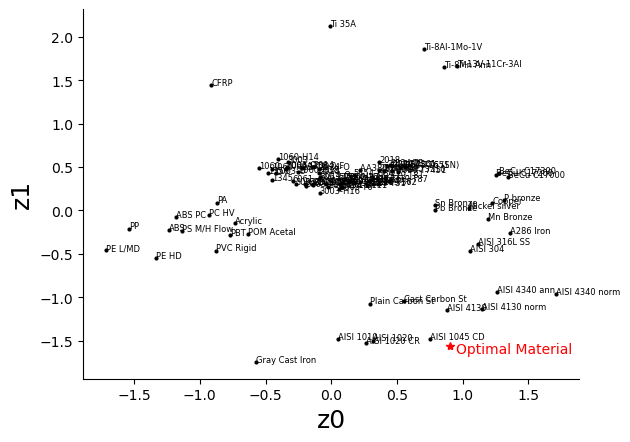

In [13]:
#zData: Coordinates of the artificial material
#z_np: Coordinates of the real materials
zData=X[0:2]
dist= np.linalg.norm(zData- z_np, axis = 1)
meanDist = np.max(dist)
distOrder = np.argsort(dist)

matToUseFromDB = {'material':[], 'confidence':[]}
for i in range(3):
  mat = dataIdentifier['name'][distOrder[i]]
  matToUseFromDB['material'].append(mat)
  confidence = 100.*(1.- (dist[distOrder[i]]/meanDist))
  matToUseFromDB['confidence'].append(confidence)
  print(f"closest material {i} : {mat} , confidence {confidence:.2F}")

print(matToUseFromDB['material'][0])



#Plots materials in the latent space + the artifical material
ltnt1, ltnt2 = 0, 1
fig, ax = plotLatent(dataIdentifier, vae, zData, 0, 1, plotHull = False, annotateHead = False,\
                                    saveFileName ='./figures_Single/optimalLatent.png')


ind = np.where(dataIdentifier['name'] == matToUseFromDB['material'][0])
ind2 = np.where(dataIdentifier['name'] == matToUseFromDB['material'][1])
ind3 = np.where(dataIdentifier['name'] == matToUseFromDB['material'][2])

matprops=10**trainInfo[ind,:]
matprop=matprops[0,0,:]
print(matprop)

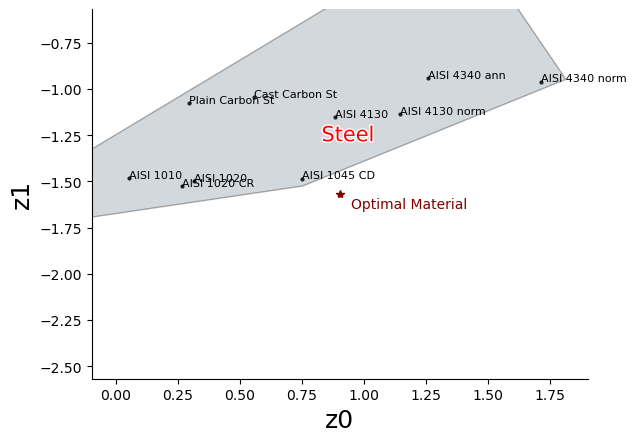

In [14]:
from matplotlib import patheffects
def plotLatentclose(dataIdentifier, vae, zData, ltnt1, ltnt2, plotHull, annotateHead, saveFileName):
    clrs = ['slategrey', 'violet', 'lawngreen', 'indigo', 'chocolate', 'gold']
    colorcol = dataIdentifier['classID']
    ptLabel = dataIdentifier['name']
    autoencoder = vae
    z = autoencoder.encoder.z.to('cpu').detach().numpy()
    fig, ax = plt.subplots()

    for i in range(np.max(colorcol) + 1):
        zMat = np.vstack((z[colorcol == i, ltnt1], z[colorcol == i, ltnt2])).T
        ax.scatter(zMat[:, 0], zMat[:, 1], c='black', s=4)
        if i == np.max(colorcol):  # removed for last class TEST
            break  # END TEST
        if plotHull:
            hull = ConvexHull(zMat)
            cent = np.mean(zMat, 0)
            pts = []
            for pt in zMat[hull.simplices]:
                pts.append(pt[0].tolist())
                pts.append(pt[1].tolist())

            pts.sort(key=lambda p: np.arctan2(p[1] - cent[1], p[0] - cent[0]))
            pts = pts[0::2]  # Deleting duplicates
            pts.insert(len(pts), pts[0])
            poly = Polygon(1.1 * (np.array(pts) - cent) + cent,
                           facecolor=clrs[i], alpha=0.3, edgecolor='black')  # 'black'
            poly.set_capstyle('round')
            plt.gca().add_patch(poly)
            ax.annotate(dataIdentifier['className'][i], (cent[0] + 0.1, cent[1] - 0.2), size=15, color='red',
                        zorder=10)  # Higher zorder to bring the annotation to the front
            txt_optimal = ax.annotate(dataIdentifier['className'][i], (cent[0] + 0.1, cent[1] - 0.2), size=15, color='red',
                        zorder=10)  # Create a new text object for the annotation
            txt_optimal.set_path_effects([patheffects.withStroke(linewidth=2, foreground="white")])  # Apply white border



    for i, txt in enumerate(ptLabel):
        if (not annotateHead) or (annotateHead and i < np.max(colorcol) + 1):
            ax.annotate(txt, (z[i, ltnt1], z[i, ltnt2]), size=8)

    plt.xlabel('z{:d}'.format(ltnt1), size=18)
    plt.ylabel('z{:d}'.format(ltnt2), size=18)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.plot(zData[0], zData[1], marker='*', color='maroon')
    ax.annotate('Optimal Material', (zData[0] * 1.05, zData[1] * 1.05), color='maroon', size=10)

    # Set the limits for x and y axes to cover the region ±1 unit from the optimal material point
    xmin, xmax = zData[0] - 1, zData[0] + 1
    ymin, ymax = zData[1] - 1, zData[1] + 1
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.savefig(saveFileName, bbox_inches='tight', dpi=200)
    return fig, ax


fig, ax = plotLatentclose(dataIdentifier, vae, zData, 0, 1, plotHull = True, annotateHead = False,\
                                    saveFileName ='./figures_Single/optimalLatentclose.png')

# Defines fixed problem

In [15]:
#Problem of minimizing mass with the tensile and compression constraints. We have 2 variables of the latent space constrained
#to the limits in the map and 6 areas with limits.
class MyProblem_fix(ElementwiseProblem):

    def __init__(self, truss, matprop, constraints, objectives, no, nc):
        super().__init__(n_var=6,
                         n_obj=no,
                         n_ieq_constr=nc,
                         xl=np.array([2e-6, 2e-6, 2e-6, 2e-6, 2e-6, 2e-6]),
                         xu=np.array([2e-2, 2e-2, 2e-2, 2e-2, 2e-2, 2e-2]))
        self.truss = truss
        self.matprop = matprop
        self.constraints = constraints
        self.objectives = objectives


    def _evaluate(self, x, out, *args, **kwargs):
        x_tensor = torch.from_numpy(x)
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([self.matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = self.matprop[2]*volume
        cost = mass*self.matprop[1]
        co2 = mass*self.matprop[4]
        energy = mass*self.matprop[5]        
        water = mass*self.matprop[6] 

        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/self.matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/self.matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['maxenergy']['maxMass']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
                
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)        

if(constraints['confidenceCons']['isOn']):
    ncons=nc-1
else:
    ncons=nc
problem_fix = MyProblem_fix(truss, matprop, constraints, objectives, no, ncons)

# Defines fixed problem settings

In [16]:
algorithm_fix = NSGA2(
    pop_size=60,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)


termination_fix = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=0.00025,
    period=20,
    n_max_gen=1000,
    n_max_evals=100000
)

# Runs the solver

In [17]:
start = time.perf_counter()
res = minimize(problem_fix,
               algorithm_fix,
               termination_fix,
               seed=1,
               save_history=True,
               verbose=True)
print('solving time : {:.2F} '.format(time.perf_counter() - start))
X = res.X
F = res.F
G = res.G



print(F)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       60 |      1 |  0.000000E+00 |  1.407596E+02 |             - |             -
     2 |       70 |      1 |  0.000000E+00 |  0.000000E+00 |  3.797843E+01 |         ideal
     3 |       80 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     4 |       90 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     5 |      100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      110 |      1 |  0.000000E+00 |  0.000000E+00 |  2.398682E+01 |         ideal
     7 |      120 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      130 |      1 |  0.000000E+00 |  0.000000E+00 |  7.2965823299 |         ideal
     9 |      140 |      1 |  0.000000E+00 |  0.000000E+00 |  2.0082408077 |         ideal
    10 |      150 |      1 |  0.000000E+00 |  0.000000E+00 |  4.8100977190 |         ideal

    91 |      960 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    92 |      970 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
solving time : 3.55 
[6.37189096]


# --------------------------------------------------------------------------------------------------

# Run solver for a given matprop

In [18]:
mat_ind = np.where(dataIdentifier['name'] == 'Plain Carbon St')
print(mat_ind)
matprops2=10**trainInfo[mat_ind,:]
print(matprops2)
matprop2=matprops2[0,0,:]




problem_matprop2 = MyProblem_fix(truss, matprop2, constraints, objectives, no, ncons)



res2 = minimize(problem_matprop2,
               algorithm_fix,
               termination_fix,
               seed=1,
               save_history=True,
               verbose=True)

X = res2.X
F = res2.F
G = res2.G


print(F)
print(G)
print(X)


(array([17], dtype=int64),)
[[[2.10000e+11 6.14000e-01 7.80000e+03 3.99826e+08 2.50000e+00
   3.20000e+07 5.00000e+01]]]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       60 |      1 |  0.000000E+00 |  1.374440E+02 |             - |             -
     2 |       70 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     3 |       80 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     4 |       90 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     5 |      100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      110 |      1 |  0.000000E+00 |  0.000000E+00 |  4.164393E+01 |         ideal
     7 |      120 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      130 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |      140 |      1 |  0.000000E+00 |  0.000000E+00 |

    90 |      950 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0299039148 |         ideal
    91 |      960 |      1 |  0.000000E+00 |  0.000000E+00 |  0.4882409824 |         ideal
    92 |      970 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    93 |      980 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    94 |      990 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    95 |     1000 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    96 |     1010 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    97 |     1020 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    98 |     1030 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0705989418 |         ideal
    99 |     1040 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   100 |     1050 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

   181 |     1860 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0191926119 |         ideal
   182 |     1870 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   183 |     1880 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   184 |     1890 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   185 |     1900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   186 |     1910 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   187 |     1920 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0067794907 |         ideal
   188 |     1930 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0046998156 |         ideal
   189 |     1940 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   190 |     1950 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   191 |     1960 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0014583476 |             f

   276 |     2810 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0022547313 |             f
   277 |     2820 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0022547313 |             f
   278 |     2830 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0023947493 |             f
   279 |     2840 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0023947493 |             f
   280 |     2850 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0023947493 |             f
   281 |     2860 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0023947493 |             f
   282 |     2870 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0023947493 |             f
   283 |     2880 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0023947493 |             f
   284 |     2890 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0023947493 |             f
   285 |     2900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0023947493 |             f
   286 |     2910 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0023947493 |             f